In [59]:
# Quietly compile autovarlamba.f90
import os
import sys
# os.system("f2py -c -m autovarlambda SR.read_write_as.for f2py_autovarlambda.f90 --quiet")
# print("\n===>>> autovarlambda compiled with f2py <<<===")

# Import other stuff
import numpy as np
import autovarlambda
import time
import pandas as pd
import yaml
import GPy
import GPyOpt
from numpy.random import seed
seed(123456)


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec

colors=['k','r','g','b','m','y','c','tab:blue',
        'tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray']
orb=['1s','2s','2p','3s','3p','3d','4s','4p','4d','4f','5s','5p','5d','5f','5g']
symbs=['o','s','v','^','>','<','o','o','o','o','o','o','o','o','o']

# Input parameters
global gridtype, cfgs, maxevals, mtype, aftype, afweight, gridtype, igrid, initer, ipol
global nlamvar, maxlam, minlam, mfunc, ifun, minst, imin, nener, wi, igi

print("\n===>>> Input parameters <<<===\n")
with open("varlam_gpyopt.yml", 'r') as stream:
    data_loaded=yaml.load(stream)

cfgs=data_loaded.get("cfgs")
if cfgs is None: raise ValueError("Error: cfgs not defined.")

initer=data_loaded.get("initer")
if initer is None: raise ValueError("Error: initer not defined.")
print(" * initial evaluations: "+str(initer))

maxevals=data_loaded.get("maxevals")
if maxevals is None: raise ValueError("Error: maxevals not defined.")
print(" * evaluations: "+str(maxevals))

mtype=data_loaded.get("mtype")
if mtype=="GP": print(" * model type: "+mtype)
elif mtype is None: 
    mtype="GP"
    print("Warning: model type not defined. Use default: GP")
else: raise ValueError("Error: "+mtype+" not implemented.")

aftype=data_loaded.get("aftype")
if aftype=="EI" or aftype=="MPI" or aftype=="LCB": print(" * acquisition function type: "+aftype)
elif aftype is None: 
    aftype="EI"
    print("Warning: acquisition function type not defined. Use default: EI")
else: raise ValueError("Error: "+mtype+" not implemented.")

afweight=data_loaded.get("afweight")
if afweight: print(" * acquisition function weight: "+str(afweight))
elif afweight is None: 
    afweight=1.
    print("Warning: acquisition function weight not defined. Use default: 1.")

gridtype=data_loaded.get("gridtype")
if gridtype=="continuous":
    igrid=0
    print(" * grid type: "+gridtype)
elif gridtype is None: 
    igrid=0
    print("Warning: grid type not defined. Use default: continuous")
else: raise ValueError("Error: "+gridtype+" not implemented.")

nlamvar=data_loaded.get("nlamvar")
if nlamvar is None: raise ValueError("Error: nlamvar not defined.")

maxlam=data_loaded.get("maxlam")
minlam=data_loaded.get("minlam")
if maxlam is None or minlam is None: raise ValueError("Error: maxlam and/or minlam not defined.")

mfunc=data_loaded.get("mfunc")
if mfunc=="Er":
    ifun=0
    print(" * minimization function: sum of weighted relative errors")
elif mfunc=="Er**2":
    ifun=1
    print(" * minimization function: sum of weighted square relative errors")
elif mfunc is None: 
    imin=0
    print("Warning: minimization function not defined. Use default: Er ")
else: raise ValueError("Error: "+mfunc+" not implemented.")

minst=data_loaded.get("minst")
if minst=="gr+ex":
    imin=0
    print(" * states included in minimization: ground + excited")
elif minst=="ex":
    imin=1
    print(" * states included in minimization: excited")
elif minst is None: 
    ifun=0
    print("Warning: states to be minimized not defined. Use default: ground + excited")
else: raise ValueError("Error: "+minst+" not implemented.")

nener=data_loaded.get("nener")
if nener is None: raise ValueError("Error: nener not defined.")

wi=data_loaded.get("wi")
if wi=="eq" or wi=="gi":
    if wi=="eq": igi=0
    if wi=="gi": igi=1
    weight=np.full(nener,1.)
    print(" * weight type: "+wi)
elif wi=="inp":
    inpweight=data_loaded.get("weight")
    linpw=len(inpweight)
    if linpw<nener: # fill the missing wi with the last input value
        for i in range(linpw,nener):
            inpweight.append(inpweight[linpw-1])
    weight=np.array(listweight)
    if inpweight is None or linpw==0:
        raise ValueError("Error: weight not defined.")
elif wi is None:
    igi=1
    print("Warning: wi not defined. Use default: eq")
else: raise ValueError("Error: "+wi+"not implemented.")

vpol=data_loaded.get("vpol")
if vpol==True: 
    ipol=1
    autovarlambda.polbck.ipol=ipol
    print(" * include polarization ON.")
else:
    print(" * no polarization.")

global ii,lpol

# Define useful functions

def atom_name(nzion):
    nzion=abs(nzion)
    atomname=['H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg']
    nname=len(atomname)
    if nzion>nname: raise ValueError("atomname not defined for Z="+str(nzion))
    for i in range(nname):
        if nzion==i+1: chatom=atomname[i] 
    return chatom

def pot_type(nzion):
    if nzion < 0:
        chtype="STO"
    else:
        chtype="TFDA"
    return chtype

# Define function for writing iteration number in a human-readable-way
def human_format(num):
    magnitude=0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000
    return '%.f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

# Define the search space domain
def myspace(minlam,maxlam):
    space=[]
    for i in range(nlamvar):
        alam=str(i+1)
        space.append({'name': 'lam'+alam, 'type': gridtype, 'domain': (minlam,maxlam)})
    return space

def mypolspace(alfd_min,alfd_max,rcut_min,rcut_max):
    polspace=({'name': 'alfd','type': 'continuous', 'domain': (alfd_min,alfd_max)},
              {'name': 'rcut','type': 'continuous', 'domain': (rcut_min,rcut_max)})
    return polspace

def mykernel(rbf,stdperiodic):
    # define RBF kernel a.k.a. squared-exponential (SE)
#    if rbf==1: kernel=GPy.kern.RBF(input_dim=nlamvar,variance=varf,lengthscale=lf,ARD=ARD)
    if rbf==1: kernel=GPy.kern.RBF(input_dim=2,variance=varf,lengthscale=lf,ARD=ARD)
#    if rbf==1 and stdperiodic==1:
#        kernel1=GPy.kern.RBF(input_dim=nlamvar,variance=varf,lengthscale=lf,ARD=ARD)
#        # define a standard periodic kernel
#        kernel2=GPy.kern.StdPeriodic(input_dim=nlamvar,variance=varf,period=None,lengthscale=None,
#                                     ARD1=ARD,ARD2=ARD)
#        kernel=kernel1*kernel2
    return kernel

# Define functions to be used
def error_relat(valexact,valcomp,neex):
    if valexact == 0.0 or valcomp == 0.0:
        error=5./neex
    else:
        error=abs((valexact-valcomp)/valexact)*100
    return error

def loss_sumwE():
    global imin
    neex=autovarlambda.eei_ls.ne
    enere=autovarlambda.eicompare.enere
    enerc=autovarlambda.eicompare.enerc
    loss=0.0
    if igi==1: weight=autovarlambda.cei_ls.gic
    if igi==0: weight=autovarlambda.cei_ls.gic*0+1.
    for i in range(imin,neex): # consider ground energy and/or-only excited states
        erp=error_relat(enere[i],enerc[i],neex)
        if ifun==1: erp=erp*erp
        loss=loss + weight[i]*erp
#         print(' {} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(i,enere[i],enerc[i],erp,weight[i],loss))
    return loss

def loss_sumaki():
    global imin
    ntrtot=autovarlambda.akicompare.ntrtot
    vakie=autovarlambda.akicompare.vakie
    vakic=autovarlambda.akicompare.vakic
    loss=0.0
    for i in range(imin,ntrtot): # consider a certain number of transitions
        erp=error_relat(vakie[i],vakic[i],ntrtot)
        if ifun==1: erp=erp*erp
        loss=loss+erp
        print(' {} {:.3e} {:.3e} {:.4f} {:.4f}'.format(i,vakie[i],vakic[i],erp,loss))
    return loss
    
def check_errlog():
    ierr=0
    errlog=os.path.exists("errlog")
    if errlog == True: 
        ierr=1
        os.system("rm errlog")
    autovarlambda.errlogbck.ierr=ierr
    return

# Define function to be minimized
def var_lambda(x):
    lam=x[0,:]
    ########################################
    check_errlog()
    autovarlambda.run_as(lam,nlamvar)
    check_errlog()
    autovarlambda.inp_comp()
    autovarlambda.compare_ei()
    ########################################    
    neex=autovarlambda.eei_ls.ne
    enere=autovarlambda.eicompare.enere
    enerc=autovarlambda.eicompare.enerc
    loss=loss_sumwE()
    return loss

def pyrun_as_pol(pol,lpol):
    check_errlog()
    autovarlambda.run_as_pol(pol,lpol)
    check_errlog()
    autovarlambda.inp_comp()
    autovarlambda.compare_ei()
    autovarlambda.compare_aki()
    return

# Define function to be minimized
def var_pol(x):
    global ii,lpol
    pol=x[0,:]
    ii=ii+1
    pyrun_as_pol(pol,lpol)
    loss_ei=loss_sumwE()
    loss_aki=loss_sumaki()
    loss=loss_ei+loss_aki
    print('{} {} {vp[0]:.{prec}f} {vp[1]:.{prec}f} {l1:.{prec}f} {l2:.{prec}f} {lt:.{prec}f}'.
          format(ii,lpol,vp=pol,l1=loss_ei,l2=loss_aki,lt=loss,prec=4))
    return loss

# Determine file name string vector from fortran subroutine data
def def_filename():
    global ncfg, filename,initer
    ncfg=autovarlambda.salgebbck.mxconf
    nzion=autovarlambda.sminimbck.nzion
    chatom=atom_name(nzion)
    chtype=pot_type(nzion)
    cfgs=str(ncfg)+"CFG"+chtype
    idrun=str(initer)+mtype+human_format(maxevals)
    filename=chatom+cfgs+"_"+idrun

# Open .out file
def open_fout():
    global fener
    fener=open(filename+".out","w")

# Define and initialize variables
def init_var():
    enere=np.zeros(nener)
    enerc=np.zeros(nener)
    neex=int()
    return enere, enerc, neex

def run_mybo_pol(space,kernel,initer,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi):
    #iseed=initer*123456
    iseed=50*123456
    seed(iseed)
    enere, enerc, neex=init_var()
    cpdas="cp das_" + str(cfgs) + "CFG das"
    os.system(cpdas)
    autovarlambda.open_files()
    autovarlambda.inp_das()
    autovarlambda.inp_obs()
    dummyne=autovarlambda.eei_ls.ne.copy()
    if nener != dummyne:
        autovarlambda.eei_ls.ne=nener
    def_filename()
    if ncfg != cfgs:
        print(" >>>> configuration mismatch !!!! ")
        sys.exit()
    open_fout()
    t0=time.time()
    global ii
    ii=0
    model=GPyOpt.models.GPModel(kernel=kernel,noise_var=noise_var,exact_feval=exact_feval,
                                optimizer='lbfgs',optimize_restarts=optimize_restarts,
                                verbose=False,ARD=ARD)
    dspace=GPyOpt.Design_space(space=space)
    objective=GPyOpt.core.task.SingleObjective(var_pol)
    initial_design=GPyOpt.experiment_design.initial_design('random',dspace,initer)
    acquisition_optimizer=GPyOpt.optimization.AcquisitionOptimizer(dspace, optimizer='lbfgs')
    acquisition=GPyOpt.acquisitions.AcquisitionEI(model,dspace,acquisition_optimizer,jitter=xi)
    evaluator=GPyOpt.core.evaluators.Sequential(acquisition)
    myBopt=GPyOpt.methods.ModularBayesianOptimization(model,dspace,objective,acquisition,
                                                      evaluator,X_init=initial_design,normalize_Y=False)
    myBopt.run_optimization(maxevals,eps=1e-7,verbosity=False)
    myBopt.plot_acquisition("polparam_"+str(initer)+"GP"+str(maxevals)+".eps")
    myBopt.save_evaluations(filename+".dat")
    t1=time.time()
    total=(t1-t0)/60.
    print_optpol(total,myBopt,filename,maxevals)
    return 

def print_optpol(total,myBopt,filename,maxevals):
    global fmin,weight,fener,lpol
    pol_best=myBopt.x_opt
    fmin=myBopt.fx_opt
    pyrun_as_pol(pol_best,lpol)
    neex=autovarlambda.eicompare.neex
    enere=autovarlambda.eicompare.enere
    enerc=autovarlambda.eicompare.enerc
    loss_best=loss_sumwE()
    erelat=[]
    erroregr=error_relat(enere[0],enerc[0],neex)
    erelat.append(erroregr)    
    print("\n Total time: {:.{prec}f} min".format(total,prec=4))
    print("\n pol = {vp[0]:.{prec}f} {vp[1]:.{prec}f} ".format(vp=pol_best,prec=4))
    print(" fmin = {:.{prec}f}".format(fmin,prec=4))
    print("\n Number of evaluations={:10d}".format(maxevals),file=fener)
    print("                  Time={:10.3f} min".format(total),file=fener)
    print("-"*80,file=fener)
    print(" Best results:",file=fener)
    print("-"*80,file=fener)
    print("\n  pol = {vp[0]:.{prec}f} {vp[1]:.{prec}f} ".format(vp=pol_best,prec=4),file=fener)
    print("\n  Ground State Energy ={:12.6f}".format(enerc[0]),
          "\n                  NIST={:12.6f}".format(enere[0]),
          "\n                   Er%={:12.4f} %".format(erroregr),file=fener)
    for i in range(1,neex):
        errorex=error_relat(enere[i],enerc[i],neex)
        erelat.append(errorex)
        print("\n       {} Excit. Energy={:12.6f}".format(i,enerc[i]),
              "\n                  NIST={:12.6f}".format(enere[i]),
              "\n                   Er%={:12.6f} %".format(errorex),file=fener)
    print("\n            Total loss={:12.4f} %".format(loss_best),file=fener)
    autovarlambda.print_ener()
    os.system("mv relat_error.dat "+filename+".erp")
    os.system("mv tmp "+filename+".das")
    fener.close()
    
    for i in erelat:
        print('{:12.4f}'.format(i,))
    
    return


===>>> Input parameters <<<===

 * initial evaluations: 20
 * evaluations: 50
 * model type: GP
 * acquisition function type: EI
 * acquisition function weight: 0.0001
 * grid type: continuous
 * minimization function: sum of weighted relative errors
 * states included in minimization: ground + excited
 * weight type: eq
 * include polarization ON.


In [50]:
alfd_min=0.001
alfd_max=0.100
rcut_min=0.50
rcut_max=1.50

 0 5.520e+08 7.227e+08 30.9252 30.9252
 1 4.200e-01 7.655e-01 82.2705 113.1957
 2 1.650e-04 2.735e-04 65.7321 178.9278
 3 7.230e+06 9.584e+07 1225.6252 1404.5530
 4 4.400e-01 -3.910e-01 188.8709 1593.4239
1 1 0.0403 1.4740 4.9777 1593.4239 1598.4015

 Total time: 0.0205 min

 pol = 0.0403 1.4740 
 fmin = 1598.4015
      0.3802
      0.3724
      0.6400
      0.4853
      0.4964
      0.8204
      0.4629
      0.3624
      0.4990
      0.4586


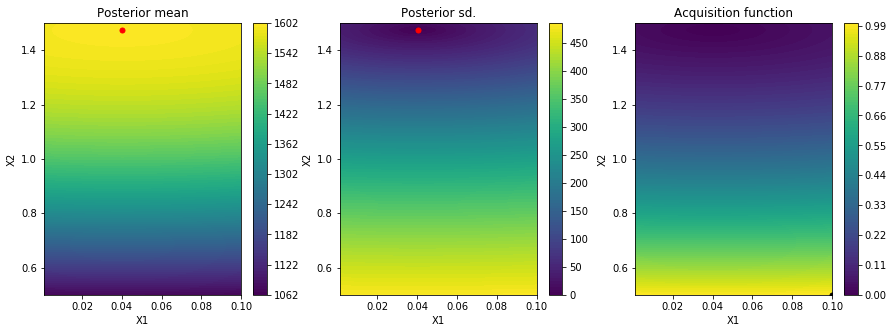

In [61]:
noise_var=None
exact_feval=True
ARD=True
varf=2.5
lf=0.1
xi=0.0001
optimize_restarts=5

initer=1
maxevals=0
nener=10
lpol=1

space=mypolspace(alfd_min,alfd_max,rcut_min,rcut_max)
kernel=mykernel(rbf=1,stdperiodic=0)
run_mybo_pol(space,kernel,initer,maxevals,varf,lf,noise_var,exact_feval,optimize_restarts,ARD,xi)